# COD 

In [ ]:
!git clone https://github.com/DengPingFan/SINet.git

Cloning into 'SINet'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 843 (delta 63), reused 22 (delta 7), pack-reused 731
Receiving objects: 100% (843/843), 14.62 MiB | 19.14 MiB/s, done.
Resolving deltas: 100% (460/460), done.


In [ ]:
!gdown --id 1iCkHXU55Or4gEtSqesijea6A5r8lVEYv

Downloading...
From: https://drive.google.com/uc?id=1iCkHXU55Or4gEtSqesijea6A5r8lVEYv
To: /content/SINet_40.pth
196MB [00:02, 93.6MB/s]


In [ ]:
!gdown --id 1vRYAie0JcNStcSwagmCq55eirGyMYGm5

Downloading...
From: https://drive.google.com/uc?id=1vRYAie0JcNStcSwagmCq55eirGyMYGm5
To: /content/COD10K-v3.zip
2.42GB [00:20, 119MB/s] 


In [ ]:
!unzip /content/COD10K-v3.zip

In [ ]:
!conda create -n SINet python=3.6

In [ ]:
!pip install -r /content/SINet/requirement.txt

In [ ]:
!pip install pillow==6.1

In [ ]:
!pip install apex

In [ ]:
from PIL import Image

In [ ]:
!python /content/SINet/MyTest.py

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img2 = mpimg.imread('/content/COD10K-v3/Train/GT_Instance/COD10K-CAM-1-Aquatic-1-BatFish-1.png')


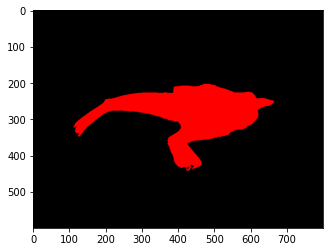

In [ ]:
plt.imshow(img2)

In [ ]:
from PIL import Image
image = Image.open("/content/first.png")
image.show()


In [ ]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import pytorch_lightning
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
import os
from tqdm.notebook import tqdm
from torchvision.utils import make_grid
from torchvision import models
import pickle

In [ ]:
batch_size_69=1

train_loader = torch.utils.data.DataLoader(
                ImageFolder('/content/dataset',  
                        transform=transforms.Compose([ transforms.Resize(256),
                        transforms.CenterCrop(224),transforms.ToTensor()])),
                        batch_size=batch_size_69, 
                        shuffle=True,
                        num_workers=4,
                        pin_memory=True)

test_loader = torch.utils.data.DataLoader(
                ImageFolder('/content/newdata', 
                        transform=transforms.Compose([ transforms.Resize(256),
                        transforms.CenterCrop(224) ,transforms.ToTensor() ])),
                        batch_size=1)

In [ ]:
# img2 = img2.resize(224)
plt.imshow(img2)


In [ ]:
for image , i in train_loader:
  for img , _ in test_loader:
    image = image.squeeze(0)
    img = img.squeeze(0)
    print(image.shape)
    plt.imshow( torch.cat( ( image, img2 ) ,dim=1 ) )
    break;

# Style transfer

In [ ]:
from __future__ import division
from torchvision import models
from torchvision import transforms
from PIL import Image
import argparse
import torch
import torchvision
import torch.nn as nn
import numpy as np


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_image(image_path, transform=None, max_size=None, shape=None):
    """Load an image and convert it to a torch tensor."""
    # image = Image.open(image_path)
    image = Image.open(image_path).convert('RGB')
    
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)
    
    if shape:
        image = image.resize(shape, Image.LANCZOS)
    
    if transform:
        image = transform(image).unsqueeze(0)
    
    return image.to(device)


class VGGNet(nn.Module):
    def __init__(self):
        """Select conv1_1 ~ conv5_1 activation maps."""
        super(VGGNet, self).__init__()
        self.select = ['0', '5', '10', '19', '28'] 
        self.vgg = models.vgg19(pretrained=True).features
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        features = []
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in self.select:
                features.append(x)
        return features


def main():
    style = '/content/multicam-pixelated-pattern-blue-vector-camouflage.jpg'
    content = '/content/desert-orange-sand-dunes-top-view-close-up-yellow-sand-texture-ornament-desert-barchans-background-desert-orange-sand-dunes-top-141147356.jpg'
    max_size = 1024
    total_step = 2000
    log_step=10
    sample_step=500
    style_weight=100
    lr=0.003

    # Image preprocessing
    # VGGNet was trained on ImageNet where images are normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225].
    # We use the same normalization statistics here.
    transform = transforms.Compose([
        transforms.CenterCrop(400),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                             std=(0.229, 0.224, 0.225))])
    
    # Load content and style images
    # Make the style image same size as the content image
    content = load_image(content, transform, max_size=max_size)
    # style = load_image(style, transform, shape=[content.size(2), content.size(3)])
    style = load_image(style, transform, max_size=max_size)
    
    # Initialize a target image with the content image
    target = content.clone().requires_grad_(True)
    
    optimizer = torch.optim.Adam([target], lr=lr, betas=[0.5, 0.999])
    vgg = VGGNet().to(device).eval()
    
    for step in range(total_step):
        
        # Extract multiple(5) conv feature vectors
        target_features = vgg(target)
        content_features = vgg(content)
        style_features = vgg(style)

        style_loss = 0
        content_loss = 0
        for f1, f2, f3 in zip(target_features, content_features, style_features):
            # Compute content loss with target and content images
            content_loss += torch.mean((f1 - f2)**2)

            # Reshape convolutional feature maps
            _, c, h, w = f1.size()
            f1 = f1.view(c, h * w)
            f3 = f3.view(c, h * w)

            # Compute gram matrix
            f1 = torch.mm(f1, f1.t())
            f3 = torch.mm(f3, f3.t())

            # Compute style loss with target and style images
            style_loss += torch.mean((f1 - f3)**2) / (c * h * w) 
        
        # Compute total loss, backprop and optimize
        loss = content_loss + style_weight * style_loss 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (step+1) % log_step == 0:
            print ('Step [{}/{}], Content Loss: {:.4f}, Style Loss: {:.4f}' 
                   .format(step+1, total_step, content_loss.item(), style_loss.item()))

        if (step+1) % sample_step == 0:
            # Save the generated image
            denorm = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
            img = target.clone().squeeze()
            img = denorm(img).clamp_(0, 1)
            torchvision.utils.save_image(img, 'output-{}.png'.format(step+1))


# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--content', type=str, default='png/content.png')
#     parser.add_argument('--style', type=str, default='png/style.png')
#     parser.add_argument('--max_size', type=int, default=400)
#     parser.add_argument('--total_step', type=int, default=2000)
#     parser.add_argument('--log_step', type=int, default=10)
#     parser.add_argument('--sample_step', type=int, default=500)
#     parser.add_argument('--style_weight', type=float, default=100)
#     parser.add_argument('--lr', type=float, default=0.003)
#     config = parser.parse_args()
#     print(config)
#     main(config)

In [ ]:
main()

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
!gdown --id 1TqaRC5FY0agW4ItuG34yq4kGFKhf6gqb
import opendatasets as od
od.download("https://www.kaggle.com/arjuntyagi25/satellite-images")

Downloading...
From: https://drive.google.com/uc?id=1TqaRC5FY0agW4ItuG34yq4kGFKhf6gqb
To: /content/kaggle.json
100% 65.0/65.0 [00:00<00:00, 116kB/s]


  0%|          | 5.00M/1.29G [00:00<00:43, 31.4MB/s]

100%|██████████| 1.29G/1.29G [00:15<00:00, 91.6MB/s]


In [ ]:
from __future__ import print_function
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
import os
from tqdm.notebook import tqdm
from torchvision.utils import make_grid
from torchvision import models
import pickle

In [ ]:
batch_size = 1

train_ds = torchvision.datasets.ImageFolder("/content/satellite-images/training_set",
                                            transform = torchvision.transforms.Compose([transforms.CenterCrop(512)
                                            , transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(train_ds , batch_size=batch_size , num_workers=2 , pin_memory=True)

In [ ]:
for img , l in train_loader:
  

# MatLab


In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch


In [12]:
red = [[1, 0] , [1 , 0.7] ]
green = [[0, 0] , [1 , 0.7] ]
blue = [[0 , 1] , [0 , 0.7] ]
truecolor_image = torch.cat(3, red, green, blue);

TypeError: ignored

# Color Extraction

In [14]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering

In [15]:
dominant_color = 5
hexadecimal_color_minibatch_kmean = []
hexadecimal_color_kmean = []
score_minibatch = []
score = []

(168, 300, 3)


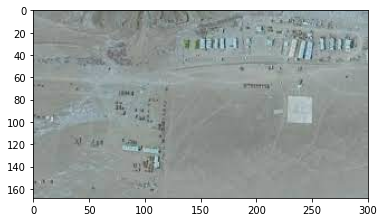

In [16]:
img = cv2.imread("/content/terrain.jpeg")

x_end , y_end = img.shape[0:2]
print(img.shape)

plt.imshow(img ,extent=[0,y_end,x_end,0])

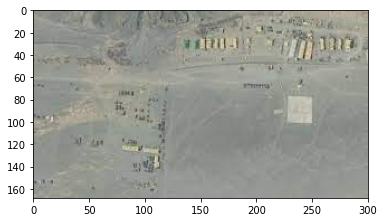

In [17]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img , extent=[0,y_end,x_end,0])

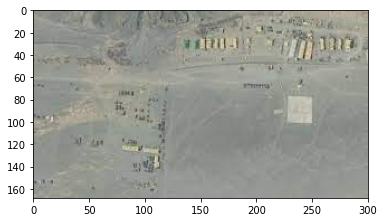

In [18]:
plt.imshow(img ,extent=[0,y_end,x_end,0])

In [19]:
original_pixel = img.shape
print(original_pixel)

(168, 300, 3)


In [20]:
pixel = img.reshape((x_end*y_end , 3))
print(pixel.shape)

(50400, 3)


## K-means minibatch

In [21]:
%%time
km = MiniBatchKMeans( n_clusters = dominant_color)
km.fit(pixel)

CPU times: user 195 ms, sys: 944 µs, total: 196 ms
Wall time: 201 ms


[[148 150 144]
 [162 163 152]
 [118 120 111]
 [138 140 135]
 [182 181 168]]


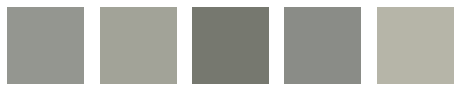

In [22]:
minibatch_centers = km.cluster_centers_
# A uint8 data type contains all whole numbers from 0 to 255.
minibatch_centers = np.array(minibatch_centers , dtype='uint8')
print(minibatch_centers)


for array in minibatch_centers:
  hexadecimal_color_minibatch_kmean.append( '#%02x%02x%02x' % (array[0], array[1], array[2]) )


#Plotting these colors

i =1
plt.figure(0,figsize=(8,2))


color = []
for x in minibatch_centers:
    plt.subplot(1,5,i)
    plt.axis("off")
    i+=1
    color.append(x)
    
    a = np.zeros((100,100,3),dtype='uint8')
    a[:,:,:] = x
    plt.imshow(a)
plt.show()



In [23]:
%%time
for i in range(dominant_color):
  sum=0
  for j in km.labels_:
    if(i == j):
      sum += 1
  score_minibatch.append(sum/len(km.labels_))

print(score_minibatch)
print(hexadecimal_color_minibatch_kmean)

[0.4272222222222222, 0.20978174603174604, 0.049484126984126985, 0.26646825396825397, 0.04704365079365079]
['#949690', '#a2a398', '#76786f', '#8a8c87', '#b6b5a8']
CPU times: user 448 ms, sys: 316 µs, total: 449 ms
Wall time: 449 ms


## SpectralClustering

In [ ]:
# %%time
km = SpectralClustering(assign_labels='discretize', n_clusters = dominant_color)
km.fit(pixel)

In [ ]:
from math import sqrt

# cluster points
points = pixel

# measure distance between two points
def distance_2point(x1, y1, x2, y2):
	return sqrt((x2-x1)**2 + (y2-y1)**2)


# estimate volume of the cluster
def volume_estimation(cluster, center):
	num_of_points = len(cluster)
	distance = []
	for i in range(num_of_points):
		distance.append(distance_2point(center[0], center[1], cluster[i][0], cluster[i][1]))

	return sum(distance)/num_of_points


# defining of new cluster center
def new_cluster_centers(cluster):
	s = list(map(sum, zip(*cluster)))
	length = len(cluster)
	return (s[0]/length, s[1]/length)


# measure distances between each two pairs of cluster centers
def center_distance(centers):
	D_ij = {}
	# offset coeficient
	k = 0
	for i in range(len(centers)):
		for j in range(k, len(centers)):
			if i == j:
				pass
			else:
				D_ij[(i,j)] = distance_2point(centers[i][0], centers[i][1], centers[j][0], centers[j][1])
		k +=1
	return D_ij


# standart deviation vector for cluster
def standart_deviation(values, center):
	n = len(values) 
	x_coord = []
	y_coord = []
	for i in range(n):
		x_coord.append((values[i][0]-center[0])**2)
		y_coord.append((values[i][1]-center[1])**2)

	x = sqrt(sum(x_coord)/n)
	y = sqrt(sum(y_coord)/n)

	return (x,y)


def cluster_points_distribution(centers, points):
	centers_len = len(centers)
	points_len = len(points)
	distances = []
	distance = []

	# define array for clusters
	clusters = [[] for i in range(centers_len)]

	# iteration throught all points
	for i in range(points_len):
		# iteration throught all centers
		for j in range(centers_len):
			distance.append(distance_2point(centers[j][0], centers[j][1], points[i][0], points[i][1]))
		distances.append(distance)
		distance = []

	# distribution
	for i in range(points_len):
		ind = distances[i].index(min(distances[i]))
		clusters[ind].append(points[i])

	return clusters


def cluster_division(cluster, center, dev_vector):
	#divide only center of clusters

	# coeficient
	k = 0.5

	max_deviation = max(dev_vector)
	index = dev_vector.index(max(dev_vector))
	g = k*max_deviation

	# defining new centers
	center1 = list(center)
	center2 = list(center)
	center1[index] += g
	center2[index] -= g

	cluster1 = []
	cluster2 = []

	return tuple(center1), tuple(center2)


def cluster_union(cluster1, cluster2, center1, center2):
	x1 = center1[0]
	x2 = center2[0]
	y1 = center1[1]
	y2 = center2[1]
	n1 = len(cluster1)
	n2 = len(cluster2)

	x = (n1*x1 + n2*x2)/(n1+n2)
	y = (n1*y1 + n2*y2)/(n1+n2)
	center = (x,y)
	cluster = cluster1 + cluster2

	return center, cluster


def clusterize():

	# initial values
	K = 3 # max cluster number
	THETA_N = 1 # for cluster elimination
	THETA_S = 1 # for cluster division
	THETA_C = 3 # for cluster union
	L = 3 # 
	I = 4 # max number of iterations
	N_c = 1 # number of primary cluster centers

	distance = [] # distances array
	centers = [] # clusters centers
	clusters = [] # array for clusters points
	iteration = 1 # number of current iteration
	
	centers.append(points[0]) # first cluster center


	while iteration <= I:
		#print ("Iteration ", iteration)
		# step 2

		"""
		if there are one cluster center - all points goes to first cluster
		otherwise we distribute points between clusters
		"""
		if len(centers) <= 1:
			clusters.append(points)
		else:
			clusters = cluster_points_distribution(centers, points)
		
		# step 3
		# eliminating small clusters (unfinished!!!!!!)
		"""
		for i in range(len(clusters)):
			if len(clusters[i]) <= THETA_N:
				print(clusters[i][i])
				item = clusters[i][i]
				points.remove(item)
				#del clusters[i]
				break
			else:
				print("else")
			break	
			"""
			
		
		# step 4
		# erasing existing centers and defining a new ones
		centers = []
		for i in range(len(clusters)):
			centers.append(new_cluster_centers(clusters[i]))

		# step 5 - estimating volumes of all clusters
		# array for clusters volume
		D_vol = []
		for i in range(len(centers)):
			D_vol.append(volume_estimation(clusters[i], centers[i]))

		# step 6
		if len(clusters) <= 1:
			D = 0
		else:		
			cluster_length = []
			vol_sum = []
			for i in range(len(centers)):
				cluster_length.append(len(clusters[i]))
				vol_sum.append(cluster_length[i]*D_vol[i])

			D = sum(vol_sum)/len(points)


		# step 7
		if iteration >= I:
			THETA_C = 0

		elif (N_c >= 2*K) or (iteration % 2 == 0):
			pass

		else:
			# step 8
			# vectors of all clusters standart deviation 
			vectors = []
			for i in range(len(centers)):
				vectors.append(standart_deviation(clusters[i], centers[i]))

			# step 9
			max_s = []
			for v in vectors:
				max_s.append(max(v[0], v[1]))

			#step 10 (cluster division)
			for i in range(len(max_s)):
				length = len(clusters[i])
				coef = 2*(THETA_N+1)

				if (max_s[i] > THETA_S) and ((D_vol[i]>D and length>coef) or N_c<float(K)/2):
					center1, center2 = cluster_division(clusters[i], centers[i], vectors[i])
					del centers[i]
					centers.append(center1)
					centers.append(center2)
					N_c += 1

				else:
					pass
		

		#for i in clusters:
		#	print(i)

		# step 11
		D_ij = center_distance(centers)
		rang = {}
		for coord in D_ij:
			if D_ij[coord] < THETA_C:
				rang[coord] = (D_ij[coord])
			else:
				pass

		"""
		# step 13 (cluster union)
		for key in rang.keys():
			cluster_union(clusters[key], clusters[key.next()], centers[key], centers[key.next()])
			N_c -= 1
			"""

		iteration += 1


	return clusters

if __name__ == '__main__':
	# if file called as a script
	cl = clusterize()
	for i in cl:
		print("Cl", i)



## K-means

In [ ]:
%%time
km = KMeans( n_clusters = dominant_color)
km.fit(pixel)

## forward

In [28]:
centers = km.cluster_centers_
# A uint8 data type contains all whole numbers from 0 to 255.
centers = np.array(centers , dtype='uint8')
print("After : ",centers)

After :  [[148 150 144]
 [162 163 152]
 [118 120 111]
 [138 140 135]
 [182 181 168]]


In [29]:
for array in centers:
  hexadecimal_color_kmean.append( '#%02x%02x%02x' % (array[0], array[1], array[2]) )


In [30]:
hexadecimal_color_kmean

['#949690', '#a2a398', '#76786f', '#8a8c87', '#b6b5a8']

In [34]:
hexadecimal_color

NameError: ignored

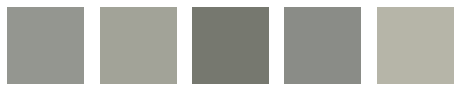

In [32]:

#Plotting these colors

i =1
plt.figure(0,figsize=(8,2))


color = []
for x in centers:
    plt.subplot(1,5,i)
    plt.axis("off")
    i+=1
    color.append(x)
    
    a = np.zeros((100,100,3),dtype='uint8')
    a[:,:,:] = x
    plt.imshow(a)
plt.show()



In [33]:
%%time
score = []
for i in range(dominant_color):
  sum=0
  for j in km.labels_:
    if(i == j):
      sum += 1
  score.append(sum/len(km.labels_))

print(score)
print(hexadecimal_color)

[0.4272222222222222, 0.20978174603174604, 0.049484126984126985, 0.26646825396825397, 0.04704365079365079]


NameError: ignored

In [35]:
# segmenting the original image
new_pixel = np.zeros((x_end*y_end , 3))

color 

[array([148, 150, 144], dtype=uint8),
 array([162, 163, 152], dtype=uint8),
 array([118, 120, 111], dtype=uint8),
 array([138, 140, 135], dtype=uint8),
 array([182, 181, 168], dtype=uint8)]

In [36]:
km.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [37]:
for i in range(new_pixel.shape[0]):
  new_pixel[i] = color[km.labels_[i]]

new_pixel = new_pixel.reshape(original_pixel)

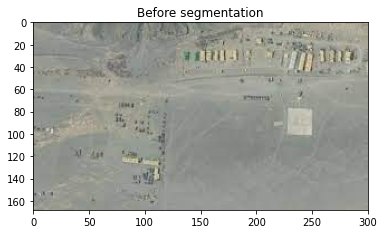

In [38]:
plt.imshow(img ,extent=[0,y_end,x_end,0])
plt.title("Before segmentation")
plt.show()

In [39]:
new_pixel /= 255

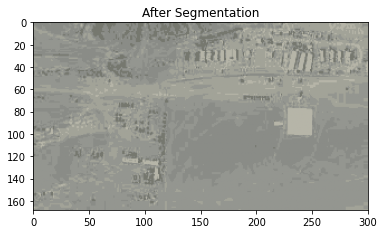

In [40]:
plt.imshow(new_pixel , extent=[0,y_end,x_end,0])
plt.title("After Segmentation")
plt.show()

In [41]:
new_pixel

array([[[0.58039216, 0.58823529, 0.56470588],
        [0.58039216, 0.58823529, 0.56470588],
        [0.58039216, 0.58823529, 0.56470588],
        ...,
        [0.63529412, 0.63921569, 0.59607843],
        [0.63529412, 0.63921569, 0.59607843],
        [0.63529412, 0.63921569, 0.59607843]],

       [[0.54117647, 0.54901961, 0.52941176],
        [0.54117647, 0.54901961, 0.52941176],
        [0.54117647, 0.54901961, 0.52941176],
        ...,
        [0.63529412, 0.63921569, 0.59607843],
        [0.63529412, 0.63921569, 0.59607843],
        [0.63529412, 0.63921569, 0.59607843]],

       [[0.54117647, 0.54901961, 0.52941176],
        [0.54117647, 0.54901961, 0.52941176],
        [0.54117647, 0.54901961, 0.52941176],
        ...,
        [0.54117647, 0.54901961, 0.52941176],
        [0.54117647, 0.54901961, 0.52941176],
        [0.54117647, 0.54901961, 0.52941176]],

       ...,

       [[0.71372549, 0.70980392, 0.65882353],
        [0.71372549, 0.70980392, 0.65882353],
        [0.63529412, 0

In [ ]:
from PIL import Image
im = Image.fromarray(new_pixel)
im.save("segmented.jpg")


In [ ]:
import scipy.misc
scipy.misc.imsave('outfile.jpg', new_pixel)

# Camogen


In [1]:
!git clone https://github.com/SYBIOTE/camogen

Cloning into 'camogen'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 82 (delta 0), reused 0 (delta 0), pack-reused 79
Unpacking objects: 100% (82/82), done.


In [ ]:
pip install camogen/


In [54]:
hexadecimal_color_minibatch_kmean

['#949690', '#a2a398', '#76786f', '#8a8c87', '#b6b5a8']

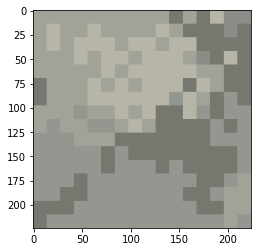

In [74]:
import camogen
import matplotlib.pyplot as plt
from camogen.generate import generate

parameters = {'width': 224, 'height': 224, 'polygon_size': 100, 'color_bleed': 5,'max_depth':8,
              'colors': hexadecimal_color_minibatch_kmean,
              'spots': {'amount': 20000/5, 'radius': {'min': 10/5, 'max': 40/5}, 'sampling_variation': 10},
              'pixelize': {'percentage': 1, 'sampling_variation': 20, 'density': {'x': 15, 'y': 15}}}
image = generate(parameters)
plt.imshow(image)
image.save('/content/camogen/images/genrated.png')

In [25]:
import camogen
import matplotlib.pyplot as plt
from camogen.generate import generate

parameters = {'width': 256, 'height': 256, 'polygon_size': 30, 'color_bleed': 6,
              'colors': hexadecimal_color,
             'spots': {'amount': 20000, 'radius': {'min': 7, 'max': 14}, 'sampling_variation': 10}}

image = generate(parameters)
plt.imshow(image)
image.save('pixelated2.png')


NameError: ignored

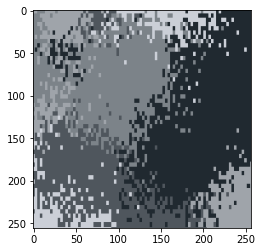

In [ ]:
parameters = {'width': 256, 'height': 256, 'polygon_size': 200, 'color_bleed': 3,
              'colors': hexadecimal_color,
             'spots': {'amount': 30, 'radius': {'min': 60, 'max': 100}, 'sampling_variation': 20},
             'pixelize': {'percentage': 1, 'sampling_variation': 20, 'density': {'x': 70, 'y': 50}}}

image = generate(parameters)
image.save('pixelated_large.png')
plt.imshow(image)

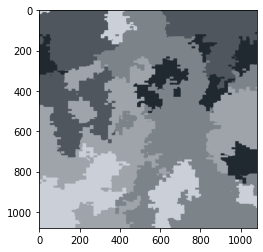

In [ ]:
parameters = {'width': 1080, 'height': 1080, 'polygon_size': 600, 'color_bleed': 5,
              'colors': hexadecimal_color,
             'spots': {'amount': 3000, 'radius': {'min': 30, 'max': 40}, 'sampling_variation': 10},
             'pixelize': {'percentage': 0.75, 'sampling_variation': 10, 'density': {'x': 60, 'y': 100}}}

image = generate(parameters)
image.save('pixelated3_large.png')

plt.imshow(image)

# extra

In [63]:
data = np.random.normal(loc=100,scale=10,size=(500,1,32))
hist = np.ones((32,20)) # initialise hist
for z in range(32):
    hist[z],edges = np.histogram(data[:,0,z],bins=np.arange(80,122,2))

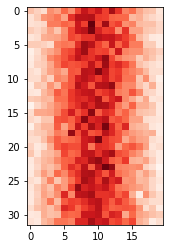

In [64]:
plt.imshow(hist,cmap='Reds')

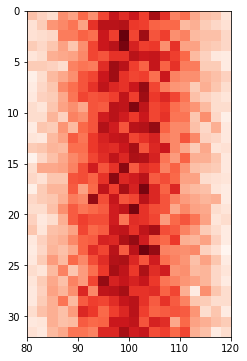

In [65]:
fig, ax = plt.subplots(figsize=(6,6))

ax.imshow(hist, cmap=plt.cm.Reds, interpolation='none', extent=[80,120,32,0])
ax.set_aspect(2) 

# saliency map



In [100]:
!git clone https://github.com/experiencor/deep-viz-keras

Cloning into 'deep-viz-keras'...
remote: Enumerating objects: 46, done.
remote: Total 46 (delta 0), reused 0 (delta 0), pack-reused 46
Unpacking objects: 100% (46/46), done.


In [103]:
pip install keras

In [101]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
import numpy as np
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import tensorflow as tf
import PIL.Image
import keras.backend as K
from matplotlib import pylab as plt

In [89]:
def show_image(image, grayscale = True, ax=None, title=''):
    if ax is None:
        plt.figure()
    plt.axis('off')
    
    if len(image.shape) == 2 or grayscale == True:
        if len(image.shape) == 3:
            image = np.sum(np.abs(image), axis=2)
            
        vmax = np.percentile(image, 99)
        vmin = np.min(image)

        plt.imshow(image, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)
        plt.title(title)
    else:
        image = image + 127.5
        image = image.astype('uint8')
        
        plt.imshow(image)
        plt.title(title)
    
def load_image(file_path):
    im = PIL.Image.open(file_path)
    im = np.asarray(im)
    
    return im - 127.5

Predicted: [('n03196217', 'digital_clock', 0.07187342)] 530


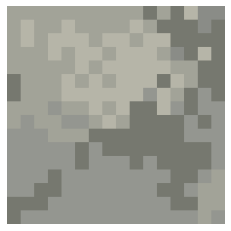

In [96]:
# Load and compile the model
model = VGG16(weights='imagenet')
model.compile(loss='mean_squared_error', optimizer='adam')

# Load an image and make the prediction
img_path = '/content/camogen/images/genrated.png'
img = load_image(img_path)
show_image(img, grayscale=False)

x = np.expand_dims(img, axis=0)

preds = model.predict(x)
label = np.argmax(preds)
print('Predicted:', decode_predictions(preds, top=1)[0], label)

In [95]:
cd ./deep-viz-keras/

[Errno 2] No such file or directory: './deep-viz-keras/'
/content/deep-viz-keras


In [106]:
from guided_backprop import GuidedBackprop
guided_bprop = GuidedBackprop(model)

AttributeError: ignored

In [93]:
mask = guided_bprop.get_smoothed_mask(x[0])
show_image(mask, ax=plt.subplot('122'), title='smoothed guided backprop')

NameError: ignored